## This is a "Keras primer" whose purpose is to familiarize with MLP and CNN using Mnist dataset (we also do some hyperparameters tuning)

In [216]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,Conv2D,Flatten,MaxPooling2D
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model

We import Mnist dataset

In [146]:
(X_train,y_train),(X_test,y_test)=mnist.load_data()

In [147]:
print X_train.shape,X_test.shape
print y_train.shape,y_test.shape
print X_train.dtype

(60000, 28, 28) (10000, 28, 28)
(60000,) (10000,)
uint8


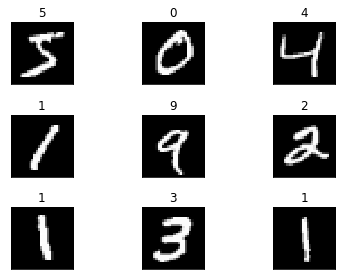

uint8


In [220]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i],cmap="gray")
    plt.title(y_train[i])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()
print X_train.dtype

We prepare Mnist dataset for analysis 

In [149]:
im_w=X_train.shape[1]
im_h=X_train.shape[2]
im_d=im_w*im_h
print im_d

784


In [150]:
MX_train=X_train.reshape(X_train.shape[0],im_d).astype("float32")
MX_test=X_test.reshape(X_test.shape[0],im_d).astype("float32")
MX_train/=255
MX_test/=255

In [151]:
My_train=to_categorical(y_train)
My_test=to_categorical(y_test)
print My_train.shape,My_test.shape

(60000, 10) (10000, 10)


We build the first simple model of MLP

In [152]:
def easy_model():
    model=Sequential()
    model.add(Dense(256,input_dim=im_d,activation="relu"))
    model.add(Dropout(0.75))
    model.add(BatchNormalization())
    model.add(Dense(256,activation="relu"))
    model.add(BatchNormalization())
    model.add(Dense(10,activation="softmax"))
    model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
    return model

In [153]:
emodel=easy_model()

In [154]:
emodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 256)               200960    
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 256)               1024      
_________________________________________________________________
dense_44 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
dense_45 (Dense)             (None, 10)                2570      
Total params: 271,370
Trainable params: 270,346
Non-trainable params: 1,024
_________________________________________________________________


We build the callbacks and fit the model

In [155]:
es=EarlyStopping(monitor="val_acc",patience=3,verbose=1)

In [156]:
mc=ModelCheckpoint("be_weights.h5",monitor="val_acc",save_best_only=True)

In [157]:
tb=TensorBoard(log_dir="./graph")

In [158]:
history=emodel.fit(MX_train,My_train,validation_data=(MX_test,My_test),callbacks=[es,mc,tb],epochs=40,batch_size=512,verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 5s 78us/step - loss: 0.7036 - acc: 0.7769 - val_loss: 0.2268 - val_acc: 0.9308
Epoch 2/40
60000/60000 [==============================] - 4s 63us/step - loss: 0.3570 - acc: 0.8901 - val_loss: 0.1731 - val_acc: 0.9439
Epoch 3/40
60000/60000 [==============================] - 4s 64us/step - loss: 0.2915 - acc: 0.9099 - val_loss: 0.1437 - val_acc: 0.9544
Epoch 4/40
60000/60000 [==============================] - 4s 63us/step - loss: 0.2601 - acc: 0.9209 - val_loss: 0.1275 - val_acc: 0.9581
Epoch 5/40
60000/60000 [==============================] - 4s 64us/step - loss: 0.2385 - acc: 0.9269 - val_loss: 0.1179 - val_acc: 0.9628
Epoch 6/40
60000/60000 [==============================] - 4s 69us/step - loss: 0.2197 - acc: 0.9315 - val_loss: 0.1095 - val_acc: 0.9661
Epoch 7/40
60000/60000 [==============================] - 4s 68us/step - loss: 0.2032 - acc: 0.9373 - val_loss: 0.1076 - val_acc

To get to tensorboard one must use the console command "Tensorboard --logdir=./" and then go to localhost:6006

In [159]:
emodel.evaluate(MX_test,My_test)

10000/10000 [==============================] - 1s 76us/step


[0.07681872550901025, 0.9777]

In [160]:
emodel.load_weights("be_weights.h5")

In [161]:
eval=emodel.evaluate(MX_test,My_test)
print eval

10000/10000 [==============================] - 1s 81us/step
[0.07317178776736837, 0.9784]


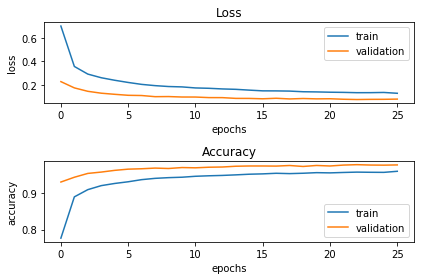

In [162]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["train","validation"])

plt.subplot(2,1,2)
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(["train","validation"])

plt.tight_layout()
plt.show()

**Observation** : it results train_loss > val_loss and val_accuracy > train_accuracy because we used dropout: some weights are put to zero during training and are instead used on the validation set. Indeed, in no_dropout_model this situation does not appear.

Now we investigate which are the indexes of the wrong predictions

In [163]:
y_pred=emodel.predict(MX_test)

In [166]:
y_testa=np.argmax(My_test,axis=1)
y_preda=np.argmax(y_pred,axis=1)
print y_testa.shape,y_preda.shape
print My_test.shape,y_pred.shape

(10000,) (10000,)
(10000, 10) (10000, 10)


In [167]:
correct_indeces = np.nonzero(y_preda == y_testa)[0]
wrong_indeces=np.nonzero(y_preda!=y_testa)[0]
my_accuracy=float(len(correct_indeces))/float(len(y_testa))
print my_accuracy==eval[1]

True


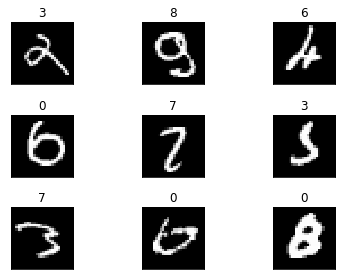

In [168]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[wrong_indeces[i]],cmap="gray")
    plt.title(y_preda[wrong_indeces[i]])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [174]:
def no_dropout_model():
    model=Sequential()
    model.add(Dense(im_d,input_dim=im_d,activation="relu",kernel_initializer='normal'))
    model.add(Dense(10,activation="softmax"))
    model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
    return model

In [175]:
ndmodel=no_dropout_model()
ndmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 784)               615440    
_________________________________________________________________
dense_49 (Dense)             (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________


In [176]:
ndhistory=ndmodel.fit(MX_train,My_train,validation_data=(MX_test,My_test),callbacks=[es],epochs=40,batch_size=512,verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 6s 107us/step - loss: 0.3893 - acc: 0.8924 - val_loss: 0.1847 - val_acc: 0.9474
Epoch 2/40
60000/60000 [==============================] - 6s 99us/step - loss: 0.1566 - acc: 0.9557 - val_loss: 0.1331 - val_acc: 0.9610
Epoch 3/40
60000/60000 [==============================] - 5s 88us/step - loss: 0.1079 - acc: 0.9701 - val_loss: 0.1011 - val_acc: 0.9708
Epoch 4/40
60000/60000 [==============================] - 5s 88us/step - loss: 0.0807 - acc: 0.9776 - val_loss: 0.0842 - val_acc: 0.9743
Epoch 5/40
60000/60000 [==============================] - 5s 88us/step - loss: 0.0615 - acc: 0.9829 - val_loss: 0.0764 - val_acc: 0.9768
Epoch 6/40
60000/60000 [==============================] - 5s 90us/step - loss: 0.0486 - acc: 0.9871 - val_loss: 0.0712 - val_acc: 0.9766
Epoch 7/40
60000/60000 [==============================] - 5s 91us/step - loss: 0.0400 - acc: 0.9895 - val_loss: 0.0667 - val_ac

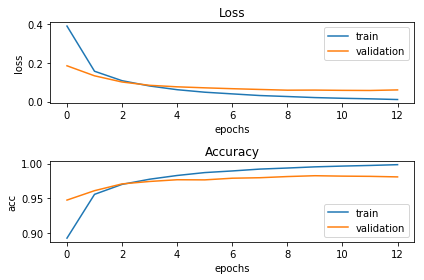

In [178]:
plt.subplot(2,1,1)
plt.plot(ndhistory.history["loss"])
plt.plot(ndhistory.history["val_loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss")
plt.legend(["train","validation"])

plt.subplot(2,1,2)
plt.plot(ndhistory.history["acc"])
plt.plot(ndhistory.history["val_acc"])
plt.xlabel("epochs")
plt.ylabel("acc")
plt.title("Accuracy")
plt.legend(["train","validation"])

plt.tight_layout()
plt.show()

Here it results val_loss > train_loss and val_acc < train_acc as we expected

Now we build a CNN model

In [187]:
def conv_model():
    model=Sequential()
    model.add(Conv2D(32,kernel_size=3,activation="relu",input_shape=(28,28,1)))
    model.add(Conv2D(32,kernel_size=3,activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(64,activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10,activation="softmax"))
    model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
    return model

In [189]:
cmodel=conv_model()
cmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_52 (Dense)             (None, 64)                294976    
_________________________________________________________________
dropout_21 (Dropout)         (None, 64)                0         
__________

Note: here X_train and X_test must have shape (28,28,1)

In [192]:
MX_trainc=MX_train.reshape(MX_train.shape[0],28,28,1).astype("float32")
MX_testc=MX_test.reshape(MX_test.shape[0],28,28,1).astype("float32")
print MX_trainc.shape,MX_testc.shape

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [193]:
cmodel.fit(MX_trainc,My_train,validation_data=(MX_testc,My_test),epochs=2,batch_size=512)

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 127s 2ms/step - loss: 0.5688 - acc: 0.8220 - val_loss: 0.1122 - val_acc: 0.9665
Epoch 2/2
60000/60000 [==============================] - 123s 2ms/step - loss: 0.1905 - acc: 0.9439 - val_loss: 0.0674 - val_acc: 0.9795


Now we do some hyperparameters tuning using GridSearchCV

In [199]:
def model_creator(activation,optimizer,model_dens,dropout_rate):
    model=Sequential()
    model.add(Dense(model_dens,input_dim=im_d,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(model_dens,activation=activation))
    model.add(BatchNormalization())
    model.add(Dense(10,activation="softmax"))
    model.compile(loss="categorical_crossentropy",optimizer=optimizer,metrics=["accuracy"])
    return model

In [200]:
def grid_search_nn(X_train,y_train,model_creator):
    model=KerasRegressor(build_fn=model_creator)
    batch_size=50
    epochs=3
    hyper_params={"activation":["softmax","relu"],"optimizer":["adam","rmsprop"],"model_dens":[256],"dropout_rate":[0.5,0.75]}
    grid=GridSearchCV(estimator=model,param_grid=hyper_params)
    grid_result=grid.fit(X_train,y_train)
    return grid_result

In [201]:
grid_res=grid_search_nn(MX_train, My_train,model_creator)

Epoch 1/1
40000/40000 [==============================] - 3s 87us/step
Epoch 1/1
40000/40000 [==============================] - 4s 90us/step
Epoch 1/1
40000/40000 [==============================] - 4s 101us/step
Epoch 1/1
40000/40000 [==============================] - 4s 105us/step
Epoch 1/1
40000/40000 [==============================] - 4s 93us/step
Epoch 1/1
40000/40000 [==============================] - 4s 102us/step
Epoch 1/1
40000/40000 [==============================] - 4s 108us/step
Epoch 1/1
40000/40000 [==============================] - 4s 105us/step
Epoch 1/1
40000/40000 [==============================] - 4s 107us/step
Epoch 1/1
40000/40000 [==============================] - 4s 97us/step
Epoch 1/1
40000/40000 [==============================] - 5s 118us/step
Epoch 1/1
40000/40000 [==============================] - 5s 121us/step
Epoch 1/1
40000/40000 [==============================] - 4s 105us/step
Epoch 1/1
40000/40000 [==============================] - 5s 119us/step
Epoch 1/1


In [210]:
means=grid_res.cv_results_['mean_test_score']
stds = grid_res.cv_results_['std_test_score']
params = grid_res.cv_results_['params']
best_score=grid_res.best_score_
best_params=grid_res.best_params_
print "MEANS =", means ,"\n"
print "STDS = ", stds, "\n"
print "PARAMETERS =", params, "\n"
print "BEST SCORE =", best_score, "\n"
print "BEST PARAMETERS =", best_params

MEANS = [-0.18208572 -0.20361475 -0.21923483 -0.25373487 -0.16531056 -0.15668848
 -0.20830678 -0.20958152] 

STDS =  [0.00667638 0.01594306 0.00766526 0.01518921 0.00308137 0.00719743
 0.00287609 0.00969213] 

PARAMETERS = [{'optimizer': 'adam', 'activation': 'softmax', 'model_dens': 256, 'dropout_rate': 0.5}, {'optimizer': 'rmsprop', 'activation': 'softmax', 'model_dens': 256, 'dropout_rate': 0.5}, {'optimizer': 'adam', 'activation': 'softmax', 'model_dens': 256, 'dropout_rate': 0.75}, {'optimizer': 'rmsprop', 'activation': 'softmax', 'model_dens': 256, 'dropout_rate': 0.75}, {'optimizer': 'adam', 'activation': 'relu', 'model_dens': 256, 'dropout_rate': 0.5}, {'optimizer': 'rmsprop', 'activation': 'relu', 'model_dens': 256, 'dropout_rate': 0.5}, {'optimizer': 'adam', 'activation': 'relu', 'model_dens': 256, 'dropout_rate': 0.75}, {'optimizer': 'rmsprop', 'activation': 'relu', 'model_dens': 256, 'dropout_rate': 0.75}] 

BEST SCORE = -0.15668848221848408 

BEST PARAMETERS = {'optimizer'

In [211]:
smart_model=model_creator(**best_params)

*Nota:* passare **train_params alla funzione create_model serve a fare unpacking del dizionario train_params, ovvero a passare i valori del dizionario come input della funzione

In [212]:
smart_model.save_weights('smart_model_w.h5')

In [213]:
smart_model.load_weights("smart_model_w.h5")

In [214]:
smart_model.save("smart_model")

In [218]:
s_model=load_model("smart_model")

In [219]:
print s_model.layers[0].get_weights()

[array([[-2.2090551e-02, -3.0906033e-02, -6.5859973e-02, ...,
        -5.0559640e-05, -1.7814212e-02, -4.6586543e-02],
       [-5.5393137e-02, -6.9302984e-02, -5.8218315e-03, ...,
         4.1379787e-02, -2.0284612e-02, -6.0163710e-02],
       [-6.7394130e-02,  3.1559244e-03, -6.1702993e-02, ...,
        -2.5518730e-02,  3.0451566e-02, -7.8399554e-03],
       ...,
       [-1.0161050e-02, -1.3890039e-02, -2.8735645e-02, ...,
        -7.0107594e-02, -3.0349445e-02, -2.1281976e-02],
       [-1.1298344e-02,  3.4962095e-02,  7.2605193e-02, ...,
        -2.7940415e-02, -2.5252253e-02, -4.0755838e-02],
       [ 3.3379167e-02,  3.9642721e-02, -6.4314879e-02, ...,
        -2.3332950e-02, -2.6827063e-02,  6.2438115e-02]], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.